In [1]:

%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from functools import reduce
from utils.models import strong_model_factory, strongly_estimated_from_tmax
from utils.tools import generate_data, load_obj, summarize_posterior, summarize_ppc, save_obj


import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
generate_data(t=47, subjects=100, random_sample=False)


Data Generated!


In [3]:
model_data = load_obj('data/bootstrap_data')
tmax = model_data['tmax']
z_CL = model_data['z_CL']
alpha = model_data['alpha']
tmaxdf = pd.DataFrame({'tmax':tmax, 'z_CL':z_CL, 'alpha':alpha, 'subject_ids': np.arange(tmax.size)})

df = pd.DataFrame({'yobs':model_data['Yobs'],
                   'y':model_data['y_est'],
                   'times':model_data['times'],
                   'subject_ids':model_data['subject_ids']})

df = df.merge(tmaxdf, how = 'left')
df.to_csv('data/simulated_data.csv', index = False)

df.loc[:, 'condition'] = False
frames = []
for name, frame in df.groupby('subject_ids'):

    frame.loc[frame.times.isin(np.arange(1, 13)),'condition'] = True
    frames.append(frame)
    
df = pd.concat(frames, axis = 0)


condition_on = df.loc[df.condition==True,:]
yobs = condition_on.yobs.values
times = condition_on.times.values
subject_ids = condition_on.subject_ids.values

no_condition = df.loc[df.condition==False, :]
ytest = no_condition.yobs.values
test_times = no_condition.times.values
test_subject_ids = no_condition.subject_ids.values

/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


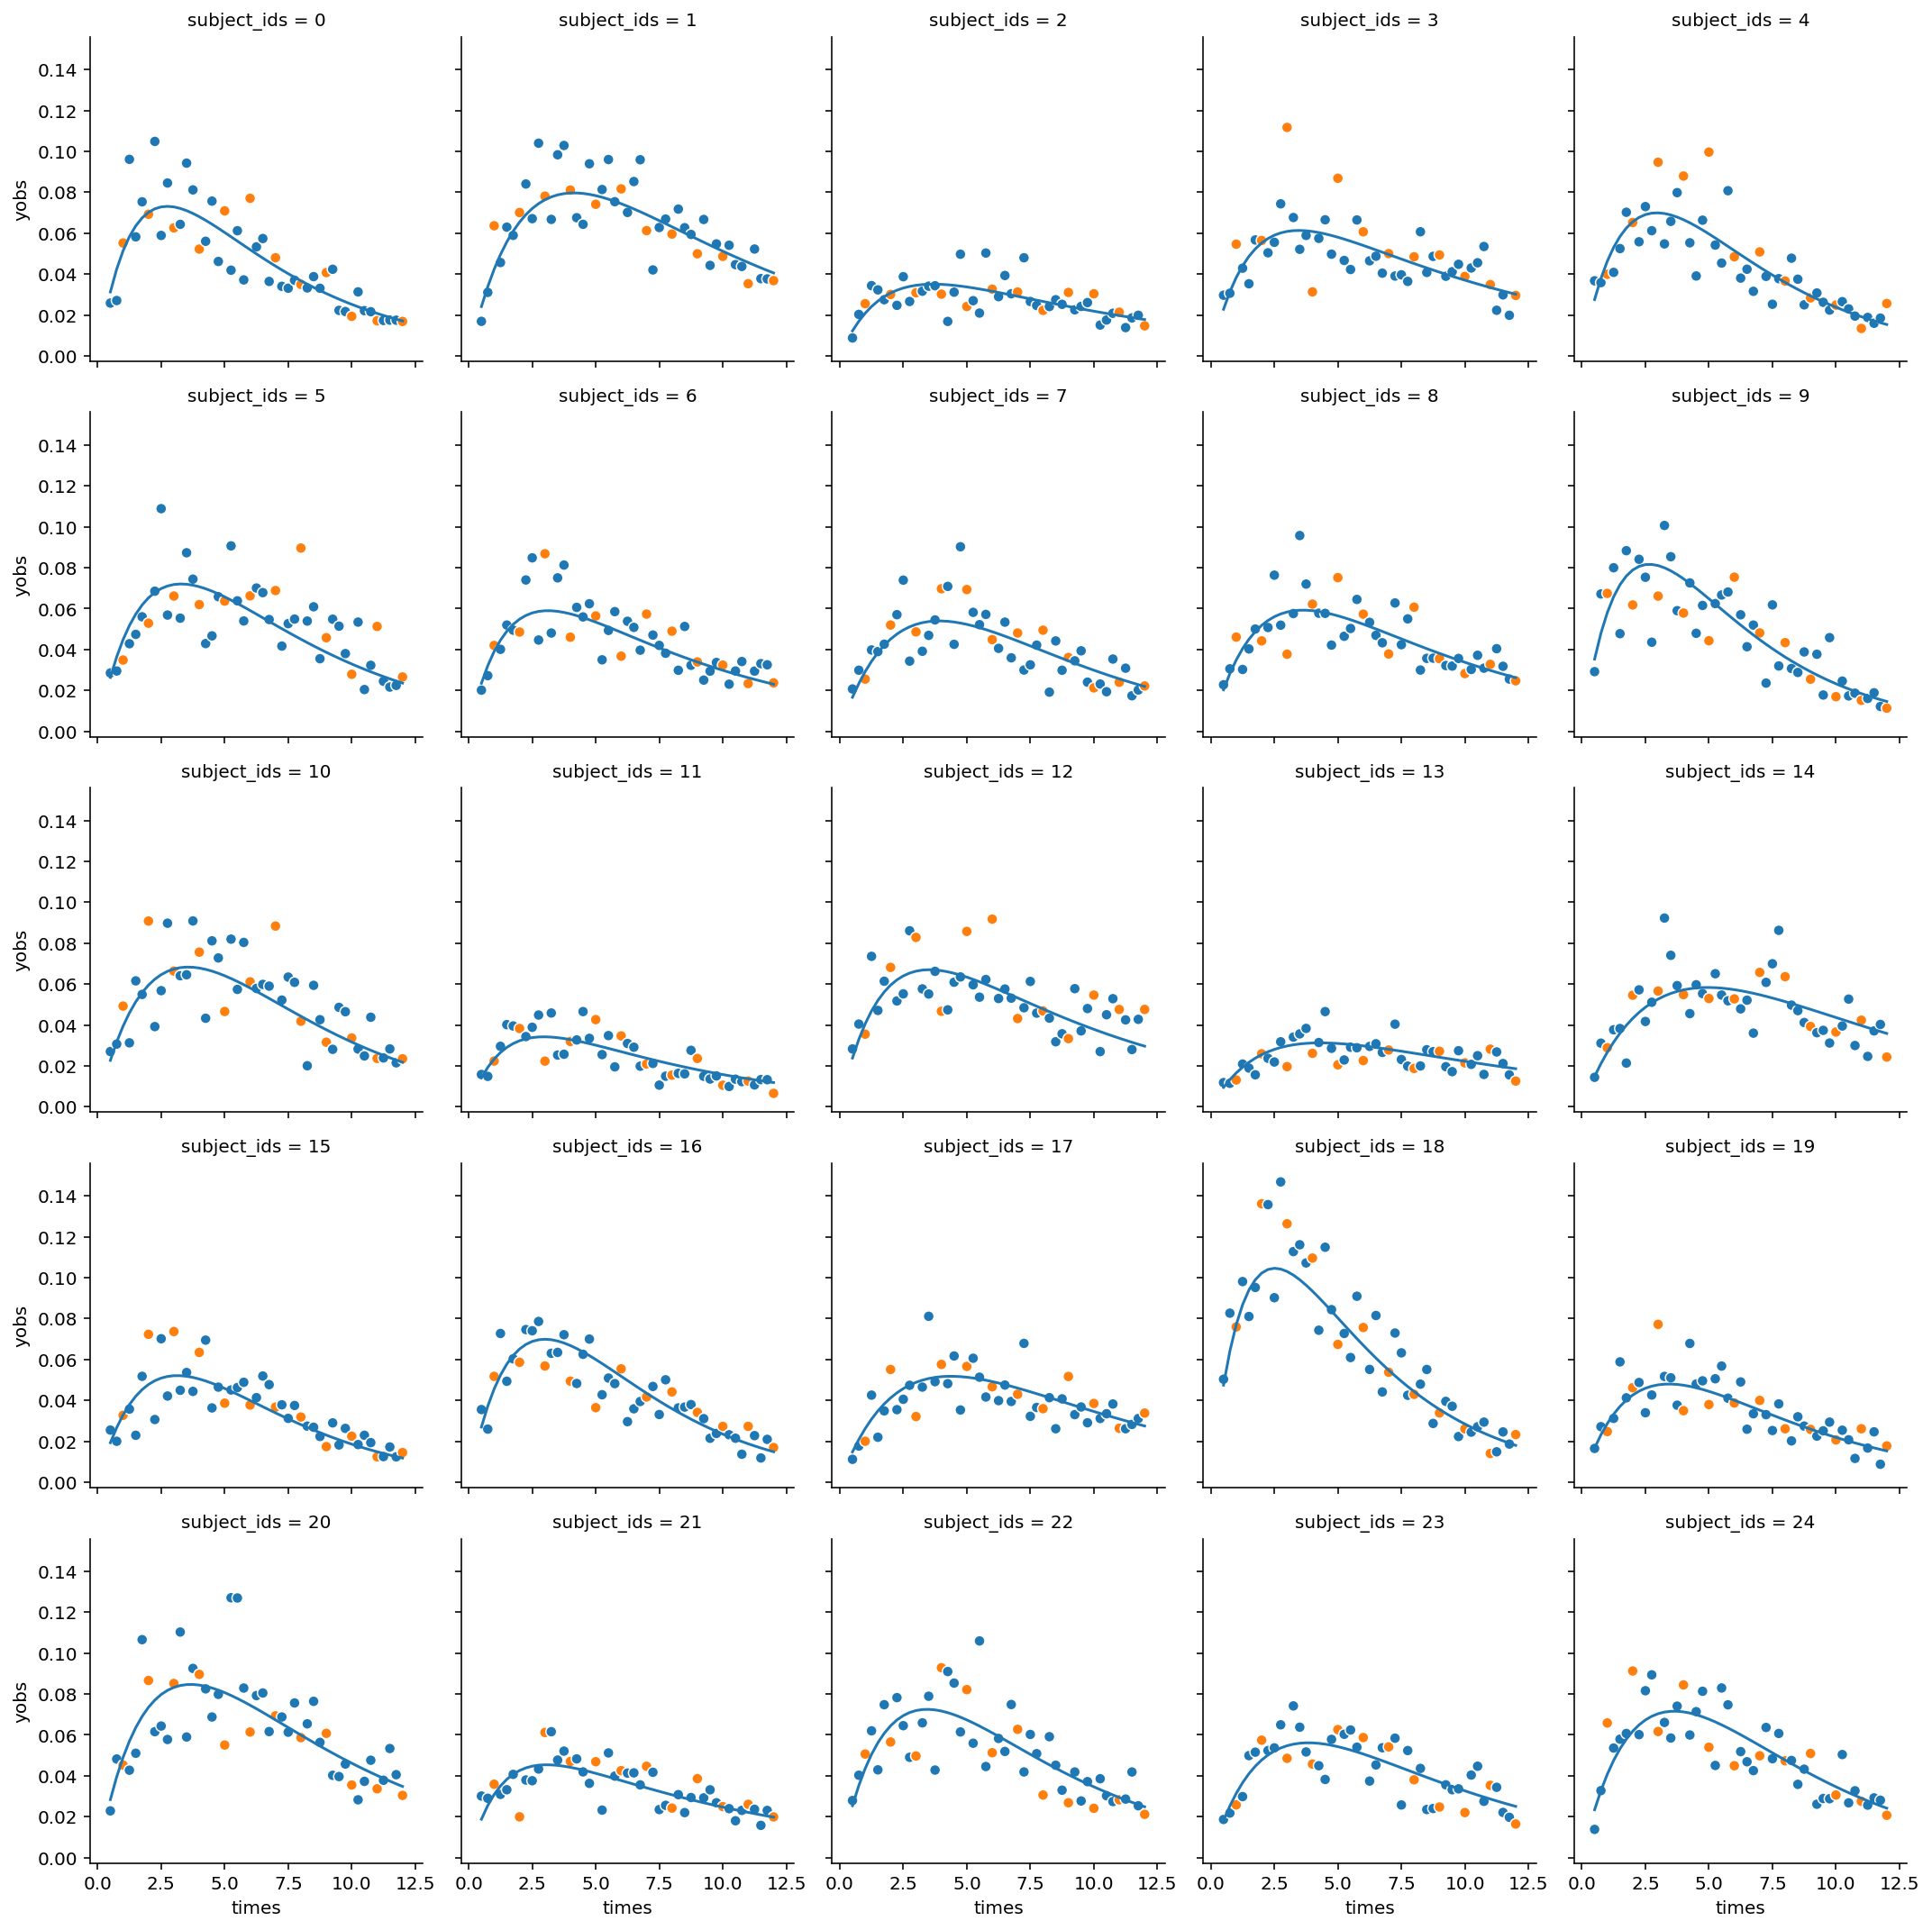

In [4]:

g = sns.FacetGrid(data = df.query('subject_ids<25'), col='subject_ids', col_wrap=5)
g.map_dataframe(sns.lineplot, 'times','y', estimator = None)
g.map_dataframe(sns.scatterplot, 'times','yobs', hue = 'condition')


# Plot Priors

In [6]:
with strongly_estimated_from_tmax(yobs, times, subject_ids, test_times, test_subject_ids) as strong_pk_model:
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws=1, tune=1, chains = 1)

    model = az.from_pymc3(prior = prior_predictive, 
                          trace = trace, 
                          coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})
    
    

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, alpha, z, z_CL, sigma_CL, mu_CL]
Sampling chain 0, 0 divergences: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]
/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.


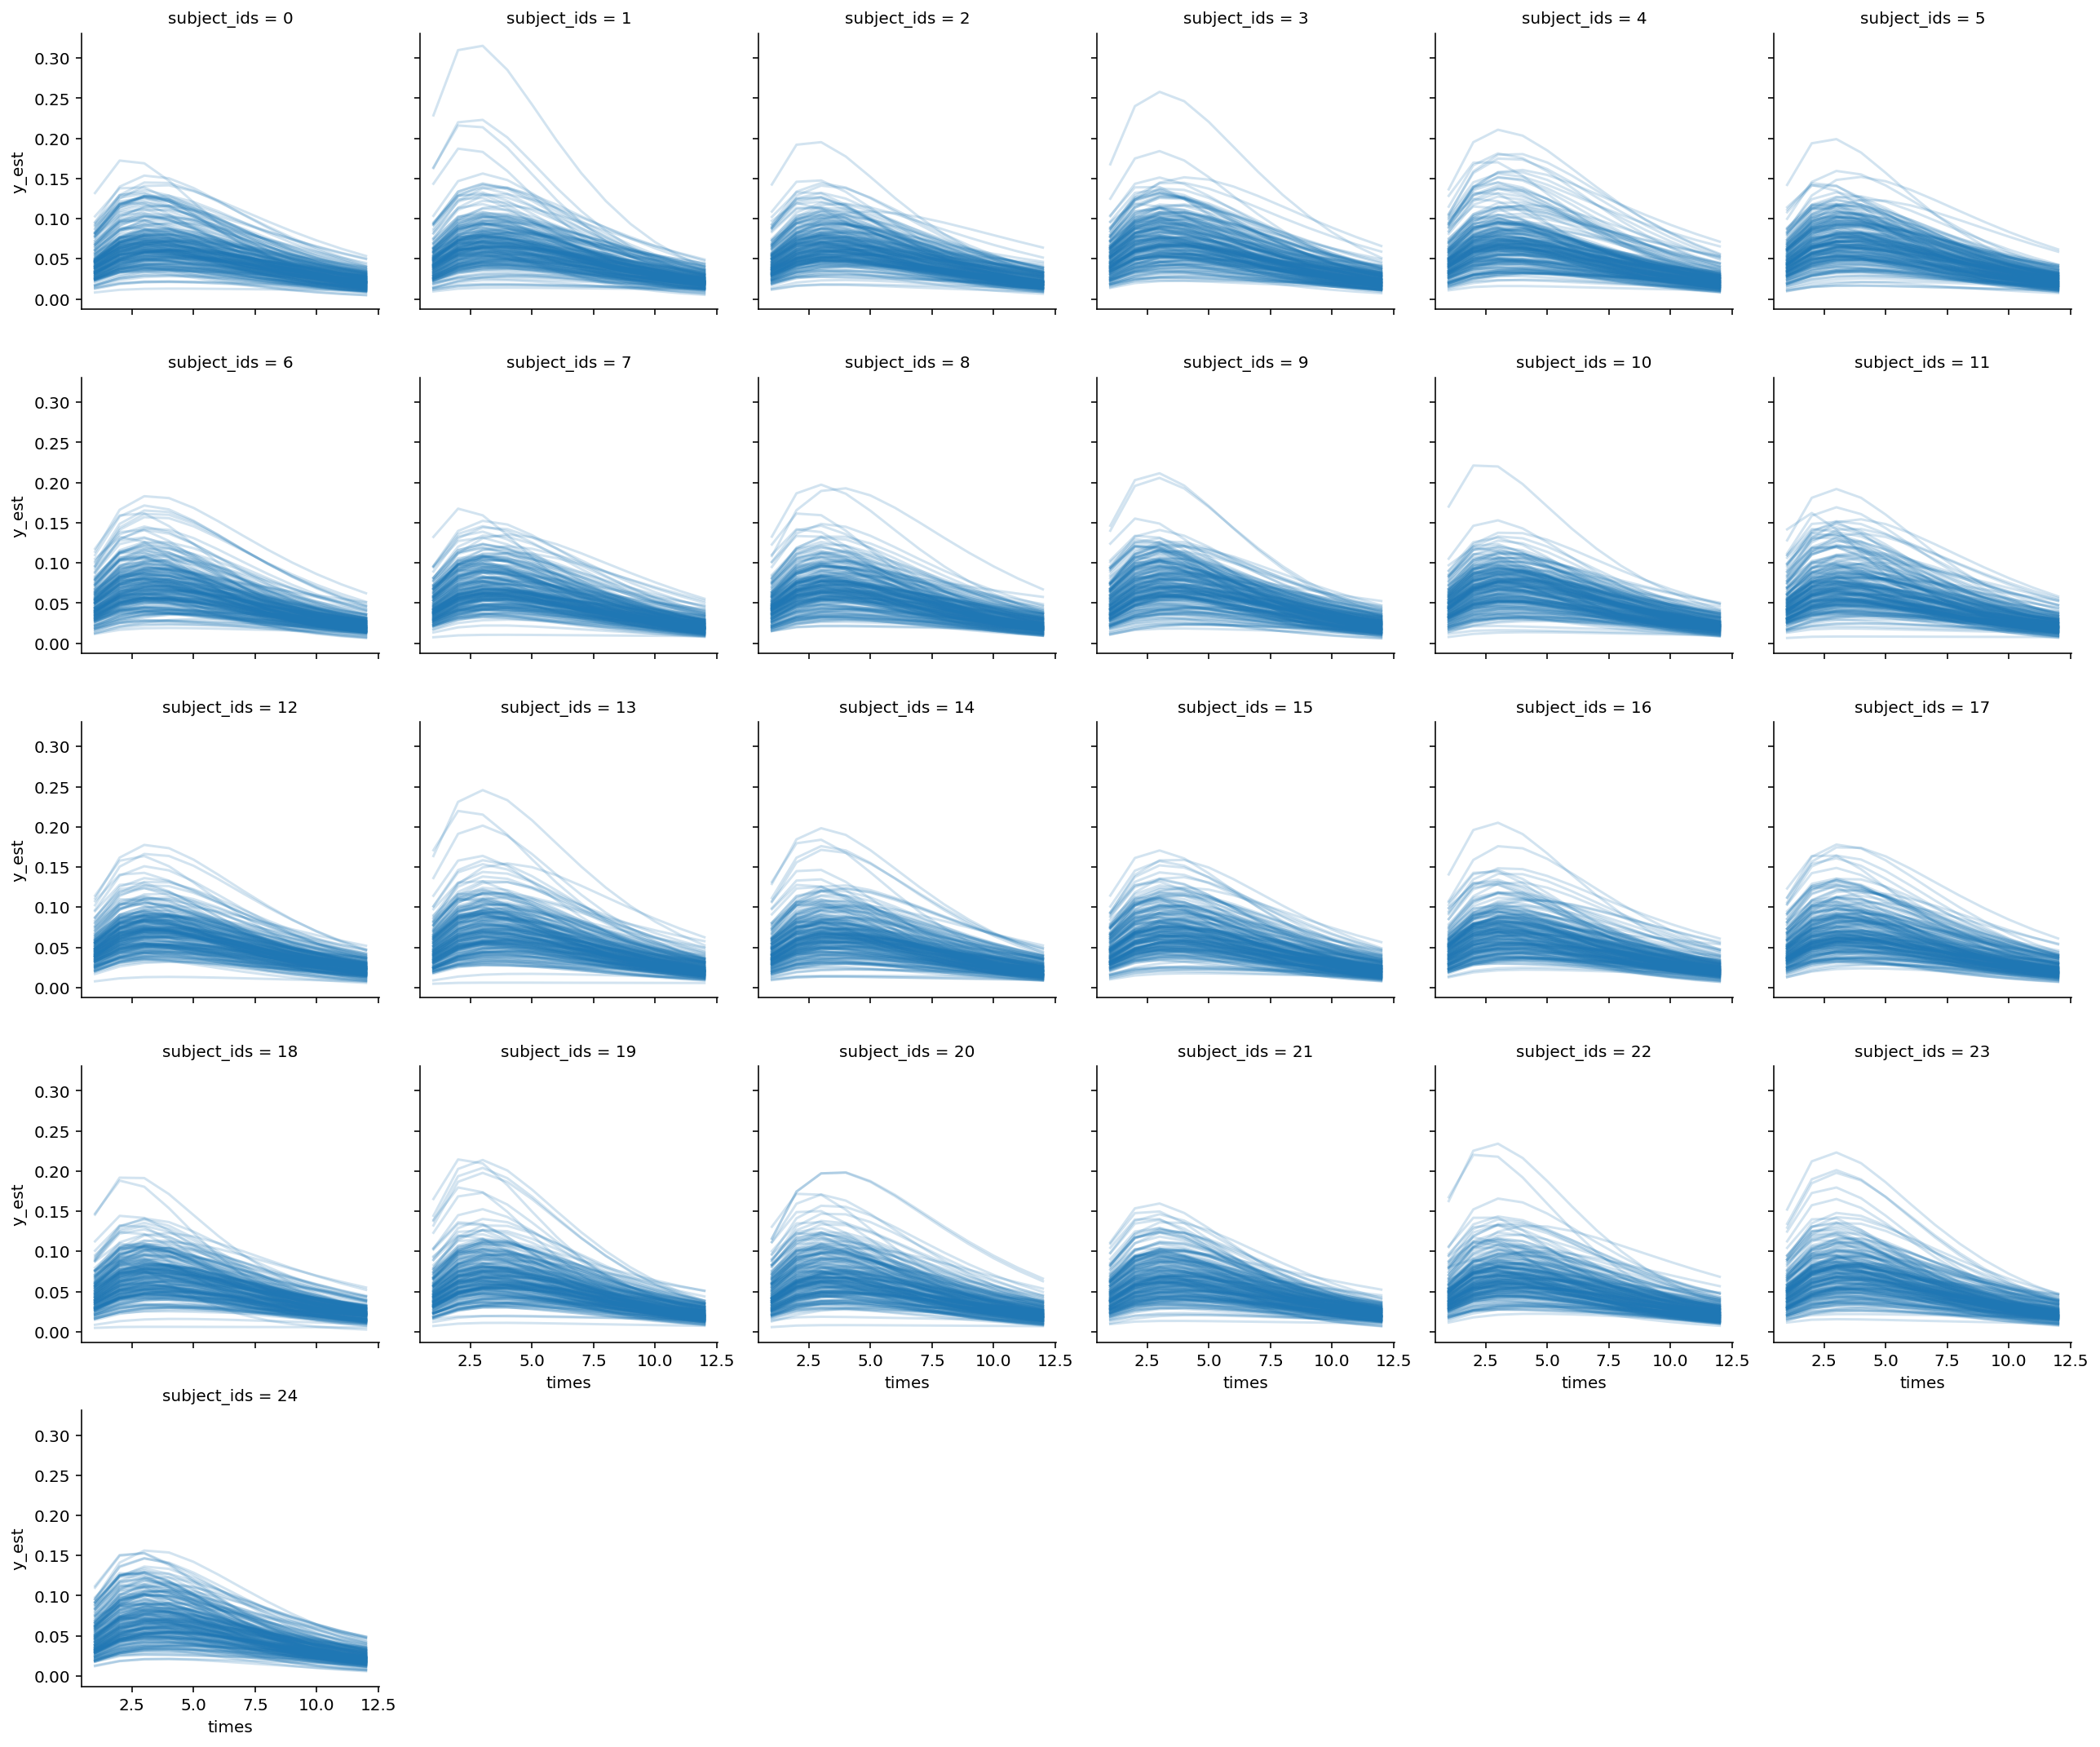

In [7]:
model_prior = model.prior.y_est.to_dataframe().query('draw<200')
dfsub = condition_on.loc[:,['times','subject_ids']].reset_index(drop = True)
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='y_est_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates.query('subject_ids<25'), col='subject_ids', col_wrap=6)
g.map_dataframe(sns.lineplot,'times','y_est', estimator = None, units = 'draw', alpha = 0.2)
    

# Strong Priors

In [8]:
with strong_pk_model:

    prior_predictive = pm.sample_prior_predictive(1000)
    
    trace = pm.sample(draws = 1000, 
                      tune = 1000, 
                      chains = 4, 
                      random_seed = 19920908,
                     target_accept = 0.99)
    
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    strong_data = az.from_pymc3(prior=prior_predictive, 
                                trace=trace, 
                                posterior_predictive=posterior_predictive)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, alpha, z, z_CL, sigma_CL, mu_CL]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [03:09<00:00, 42.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:06<00:00, 578.46it/s]


In [9]:
with strong_pk_model:
    strong_posterior_predictions = pm.sample_posterior_predictive(trace, var_names=['y_pred'])


100%|██████████| 4000/4000 [00:04<00:00, 802.09it/s] 


In [52]:

with strong_pk_model:
    maps = pm.find_MAP(tol = 1e-8)

logp = 3,823.3, ||grad|| = 0.70313: 100%|██████████| 347/347 [00:00<00:00, 1149.00it/s]


/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


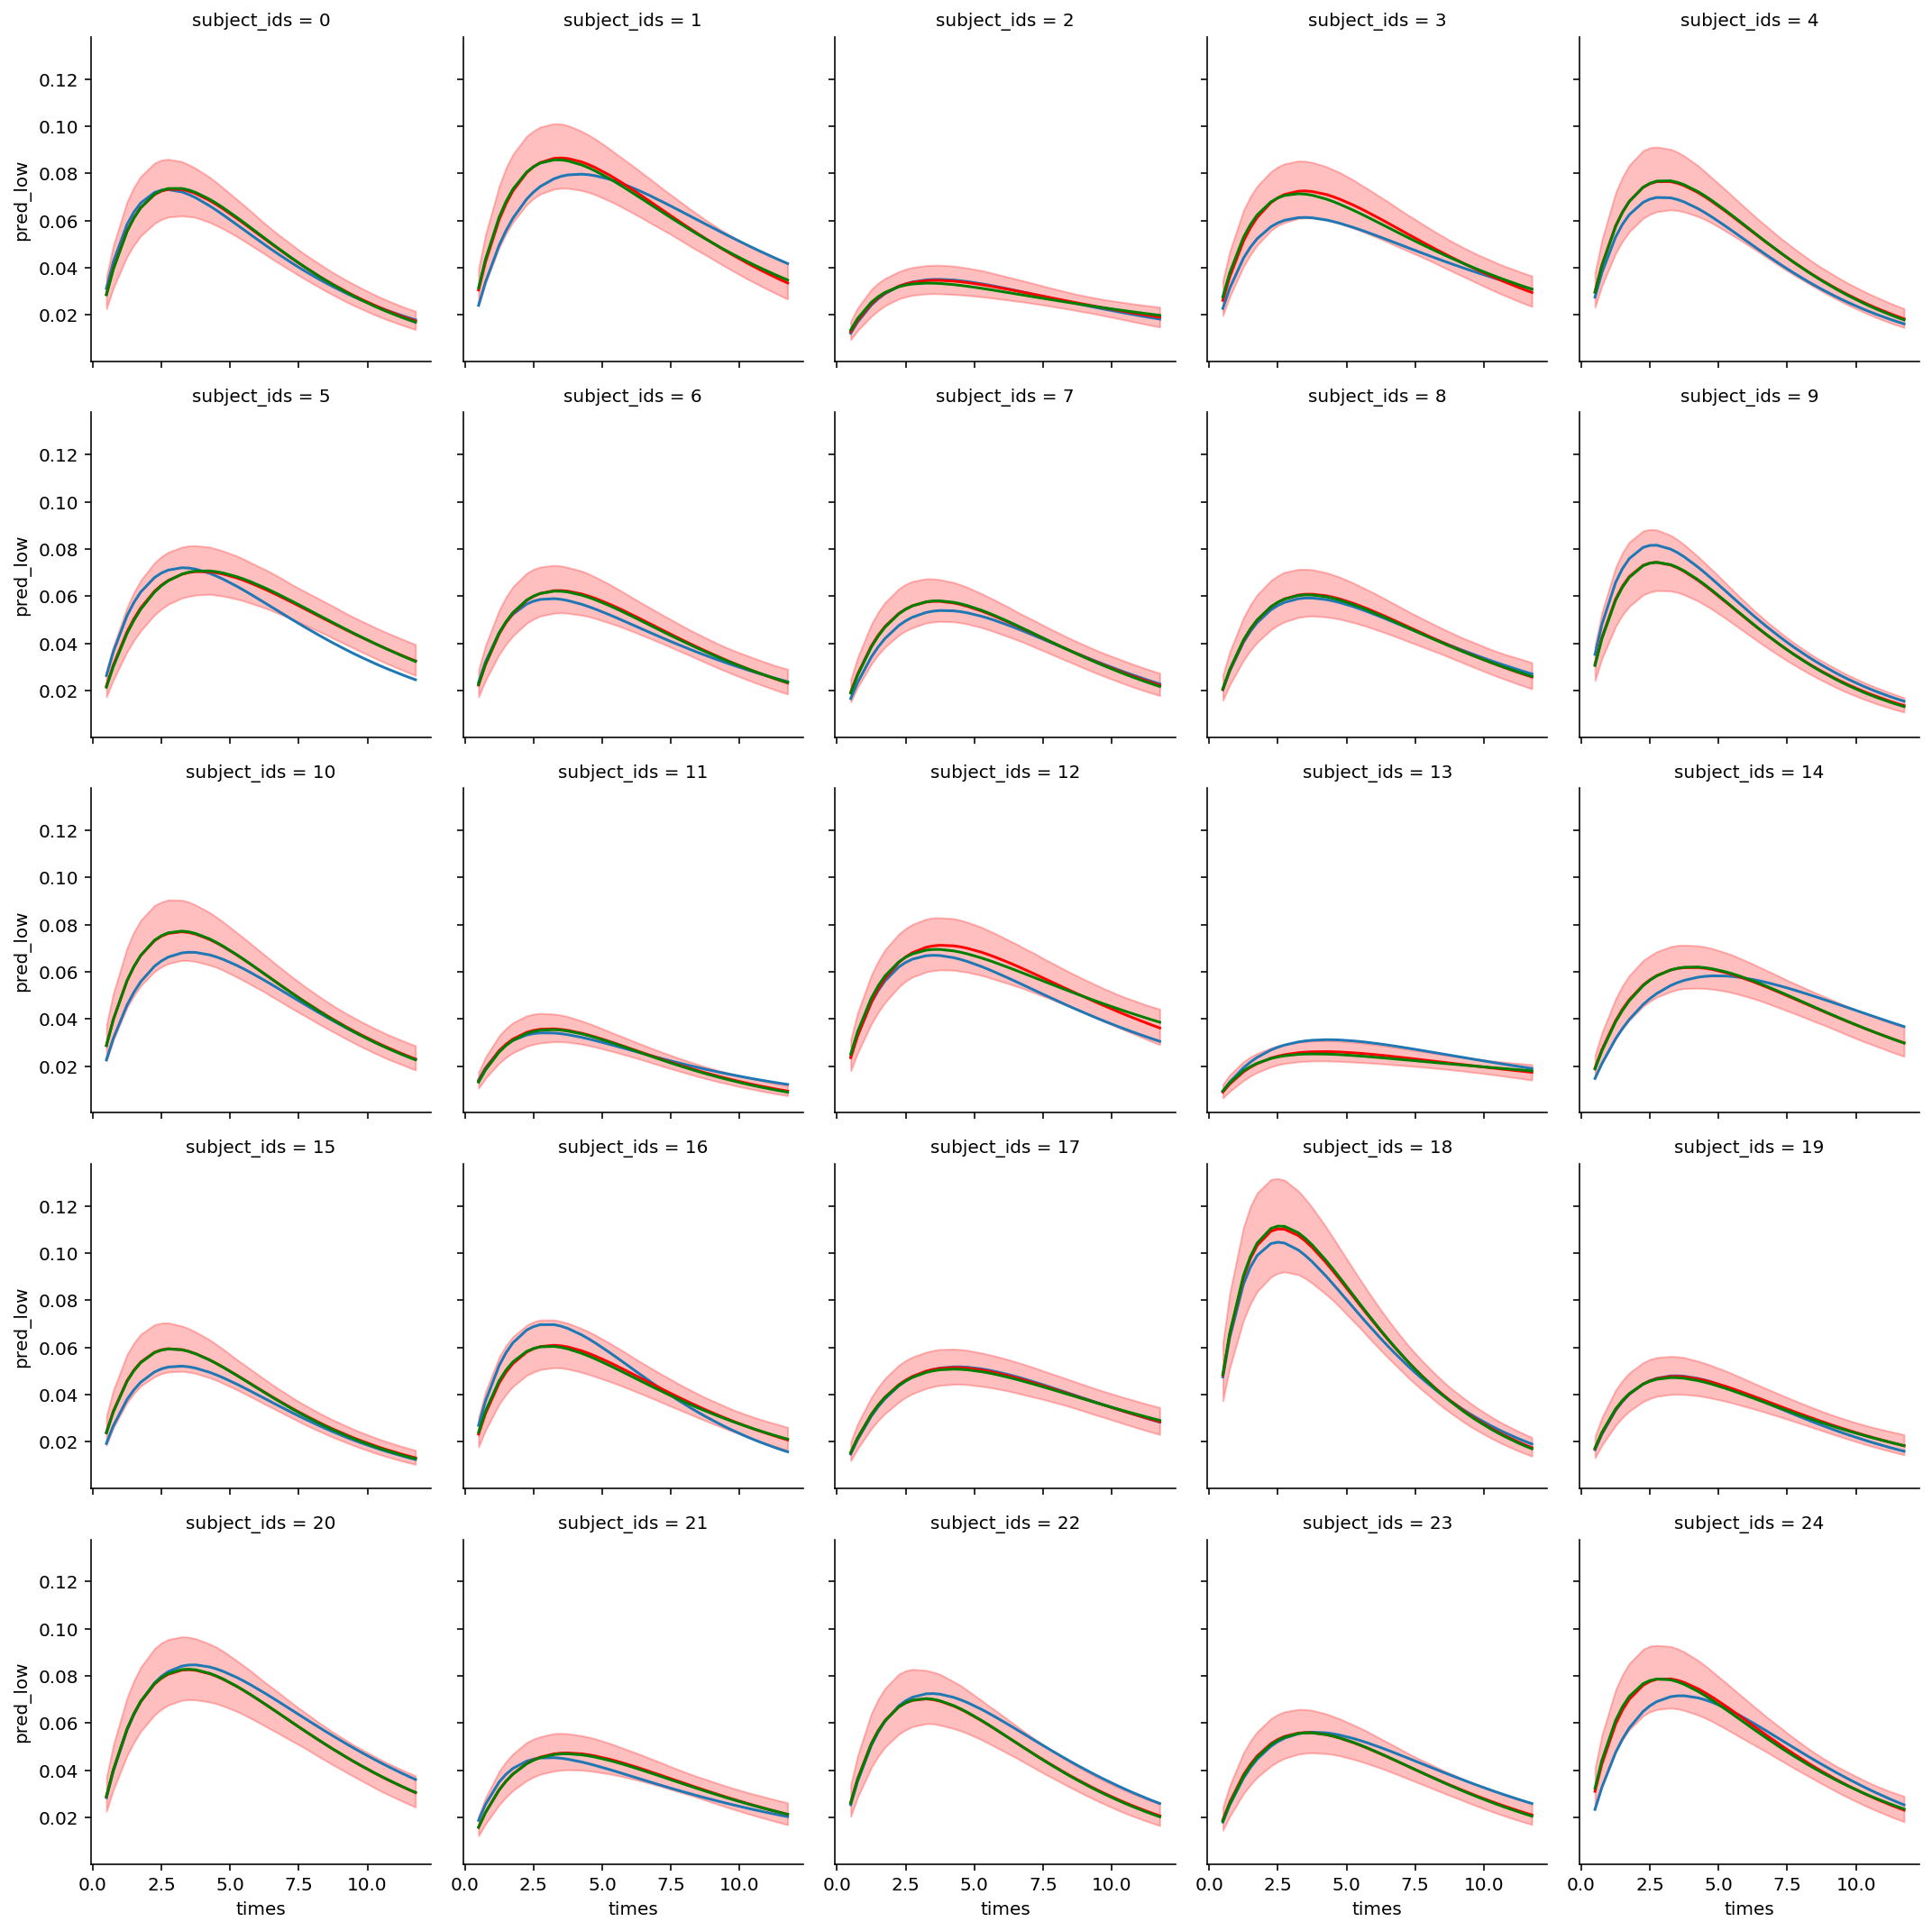

In [53]:
no_condition.loc[:,'pred'] = np.mean(strong_posterior_predictions['y_pred'], axis = 0)
no_condition.loc[:,'pred_low'] = np.quantile(strong_posterior_predictions['y_pred'], 0.025, axis = 0 )
no_condition.loc[:,'pred_high'] = np.quantile(strong_posterior_predictions['y_pred'], 0.975, axis = 0 )
no_condition.loc[:,'map_pred'] = maps['y_pred']

g = sns.FacetGrid(data = no_condition.query('subject_ids<25'), col='subject_ids', col_wrap=5)
g.map_dataframe(sns.lineplot, 'times','y', estimator = None)
# g.map_dataframe(sns.scatterplot, 'times','yobs')
g.map_dataframe(sns.lineplot, 'times','pred', estimator = None, color = 'red')
g.map_dataframe(sns.lineplot, 'times','map_pred', estimator = None, color = 'g')


g.map_dataframe(plt.fill_between, 'times', 'pred_low', 'pred_high', alpha = 0.25, color = 'red')